In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('supervised_dataset.csv')
df.head()

,Unnamed: 0,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification
0,0,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,0.000812,0.004066,85.643243,5405,default,1460,1295,451,E,normal
1,1,4c486414-d4f5-33f6-b485-24a8ed2925e8,0.000063,0.002211,16.166805,519,default,9299,8447,302,E,normal
2,2,7e5838fc-bce1-371f-a3ac-d8a0b2a05d9a,0.004481,0.015324,99.573276,6211,default,255,232,354,E,normal
3,3,82661ecd-d87f-3dff-855e-378f7cb6d912,0.017837,0.014974,69.792793,8292,default,195,111,116,E,normal
4,4,d62d56ea-775e-328c-8b08-db7ad7f834e5,0.000797,0.006056,14.952756,182,default,272,254,23,E,normal


In [3]:
df.isnull().sum()

Unnamed: 0                        0
_id                               0
inter_api_access_duration(sec)    4
api_access_uniqueness             4
sequence_length(count)            0
vsession_duration(min)            0
ip_type                           0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
classification                    0
dtype: int64

In [4]:
df_cleaned = df.dropna()

In [5]:
df_cleaned.isnull().sum()

Unnamed: 0                        0
_id                               0
inter_api_access_duration(sec)    0
api_access_uniqueness             0
sequence_length(count)            0
vsession_duration(min)            0
ip_type                           0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
classification                    0
dtype: int64

In [6]:
# Clean the dataset by dropping unnecessary columns and handling missing values
df_cleaned = df_cleaned.drop(columns=['Unnamed: 0', '_id']).dropna()

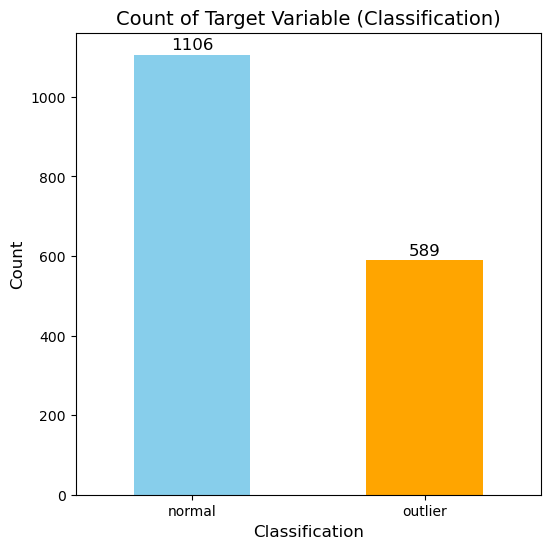

In [7]:
# 2. Plot target variable (classification) with count
plt.figure(figsize=(6, 6))
df_cleaned['classification'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Count of Target Variable (Classification)', fontsize=14)
plt.xlabel('Classification', fontsize=12)
plt.ylabel('Count', fontsize=12)
# Add counts above the bars without decimal places
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height() + 5, f'{int(p.get_height())}', 
             ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=0)
plt.show()

In [8]:
# Perform One-Hot Encoding on categorical columns (ip_type, source)
df_encoded = pd.get_dummies(df_cleaned, columns=['ip_type', 'source'], drop_first=True)
df_encoded['classification'] = df_encoded['classification'].map({
    'normal': 1,
    'outlier': -1
})

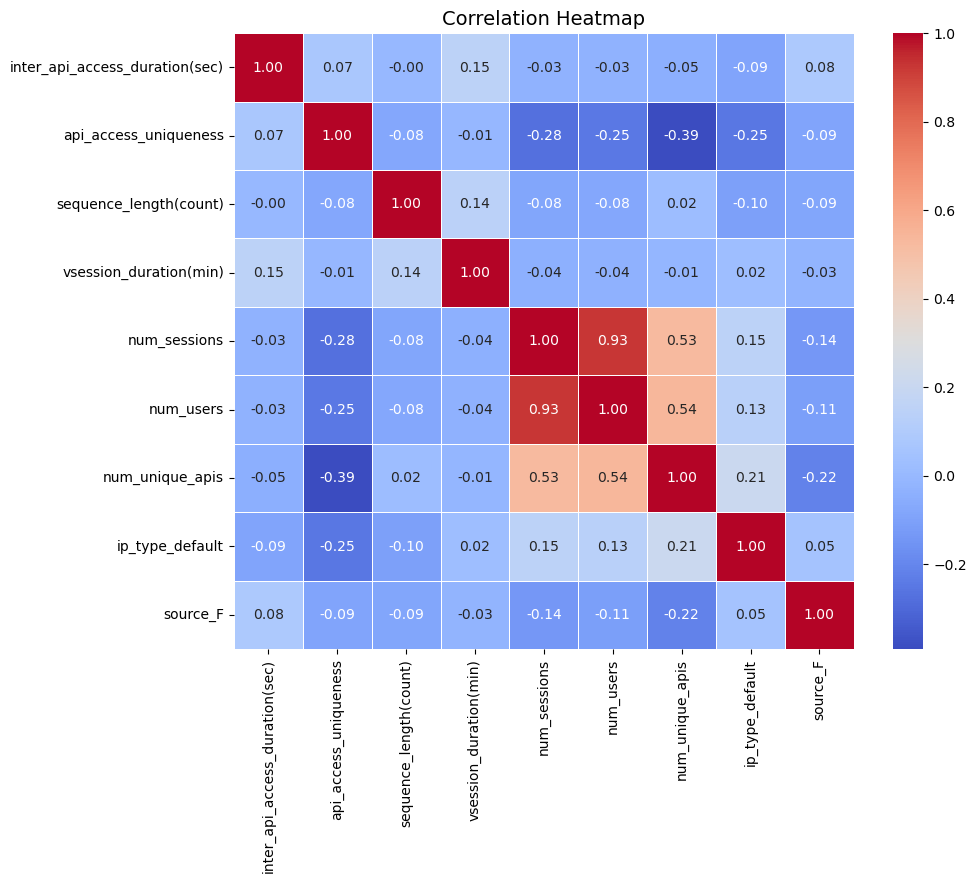

In [9]:
# Plot Correlation Heatmap
X_encoded = df_encoded.drop(columns=['classification'])
corr = X_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

In [10]:
# Identify and drop highly correlated features (abs(corr) > 0.70)
# Only consider upper triangle of the correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col].abs() > 0.70)]
print("Dropping highly correlated columns:", to_drop)

# Drop the highly correlated columns
df_encoded_reduced = df_encoded.drop(columns=to_drop)

# Display the remaining features
print("Remaining features:", df_encoded_reduced.columns.tolist())

Dropping highly correlated columns: ['num_users']
Remaining features: ['inter_api_access_duration(sec)', 'api_access_uniqueness', 'sequence_length(count)', 'vsession_duration(min)', 'num_sessions', 'num_unique_apis', 'classification', 'ip_type_default', 'source_F']


In [11]:
# Split the data into training (benign only) and testing (complete dataset)
X_train = df_encoded[df_encoded['classification'] == 1].drop(columns=['classification'])
y_train = df_encoded[df_encoded['classification'] == 1]['classification']

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1106 entries, 0 to 1105
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   inter_api_access_duration(sec)  1106 non-null   float64
 1   api_access_uniqueness           1106 non-null   float64
 2   sequence_length(count)          1106 non-null   float64
 3   vsession_duration(min)          1106 non-null   int64  
 4   num_sessions                    1106 non-null   int64  
 5   num_users                       1106 non-null   int64  
 6   num_unique_apis                 1106 non-null   int64  
 7   ip_type_default                 1106 non-null   bool   
 8   source_F                        1106 non-null   bool   
dtypes: bool(2), float64(3), int64(4)
memory usage: 71.3 KB


In [13]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 1106 entries, 0 to 1105
Series name: classification
Non-Null Count  Dtype
--------------  -----
1106 non-null   int64
dtypes: int64(1)
memory usage: 17.3 KB


In [14]:
X_test = df_encoded.drop(columns=['classification'])
y_test = df_encoded['classification']

In [15]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train One-Class SVM on the benign (normal) data
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
ocsvm.fit(X_train_scaled)

OneClassSVM(gamma='auto', nu=0.05)

In [16]:
# Predict on the complete test dataset (which includes both benign and malicious data)
raw_pred = ocsvm.predict(X_test_scaled)
pred_labels = np.where(raw_pred == 1, 1, -1)

In [17]:
# Convert to binary for evaluation (0=normal, 1=anomaly)
y_true_bin = np.where(y_test == 1, 0, 1)
y_pred_bin = np.where(pred_labels == 1, 0, 1)

In [18]:
# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_true_bin, y_pred_bin))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1106
           1       0.91      1.00      0.95       589

    accuracy                           0.97      1695
   macro avg       0.96      0.97      0.96      1695
weighted avg       0.97      0.97      0.97      1695



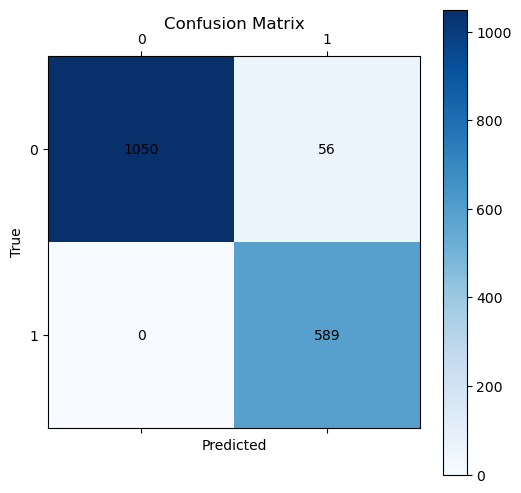

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_true_bin, y_pred_bin)
plt.figure(figsize=(6, 6))
plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix', pad=20)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')
plt.show()

In [20]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'nu': [0.01, 0.05, 0.1, 0.2],  # The proportion of outliers in the dataset (nu)
    'gamma': ['scale', 'auto', 0.001, 0.01],  # Kernel coefficient
    'kernel': ['rbf', 'linear'],  # Kernel types
}

In [21]:
# Initialize the One-Class SVM
ocsvm = OneClassSVM()

In [22]:
# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=ocsvm, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

In [23]:
# Fit the model on the training data using GridSearchCV
grid_search.fit(X_train_scaled)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=OneClassSVM(), n_jobs=-1,
             param_grid={'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['rbf', 'linear'],
                         'nu': [0.01, 0.05, 0.1, 0.2]},
             scoring='accuracy', verbose=1)

In [24]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")

Best hyperparameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
Best cross-validation accuracy: nan


In [25]:
# Train the One-Class SVM model with the best parameters
best_ocsvm = grid_search.best_estimator_

In [26]:
# Predict on the complete test dataset (which includes both benign and malicious data)
raw_pred = best_ocsvm.predict(X_test_scaled)
pred_labels = np.where(raw_pred == 1, 1, -1)

In [27]:
# Convert to binary for evaluation (0=normal, 1=anomaly)
y_true_bin = np.where(y_test == 1, 0, 1)
y_pred_bin = np.where(pred_labels == 1, 0, 1)

In [28]:
# Print classification metrics for the tuned model
print("\nClassification Report (After Hyperparameter Tuning):")
print(classification_report(y_true_bin, y_pred_bin))


Classification Report (After Hyperparameter Tuning):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1106
           1       0.96      1.00      0.98       589

    accuracy                           0.98      1695
   macro avg       0.98      0.99      0.98      1695
weighted avg       0.99      0.98      0.98      1695



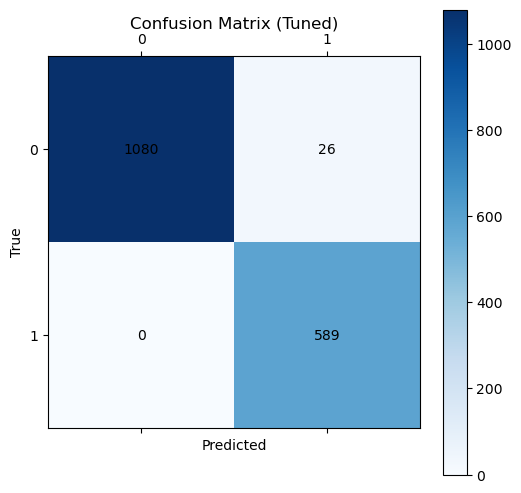

In [29]:
# Confusion Matrix for the tuned model
cm = confusion_matrix(y_true_bin, y_pred_bin)
plt.figure(figsize=(6, 6))
plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix (Tuned)', pad=20)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')
plt.show()

## Hybrid method (benign + some labeled anomaly data) 

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [31]:
# Split the data into benign (normal) and anomaly data
benign_data = df_encoded[df_encoded['classification'] == 1]
anomaly_data = df_encoded[df_encoded['classification'] != 1]

In [32]:
# Take 70% of the normal data and 30% of the anomaly data for training
benign_train = benign_data.sample(frac=0.7, random_state=42)
anomaly_train = anomaly_data.sample(frac=0.2, random_state=42)

In [33]:
# Combine the benign and anomaly data for hybrid training
train_data = pd.concat([benign_train, anomaly_train])

In [34]:
# Take the remaining 30% of the normal data and 80% of the anomaly data for testing
benign_test = benign_data.drop(benign_train.index)
anomaly_test = anomaly_data.drop(anomaly_train.index)

In [35]:
# Combine the benign and anomaly data for hybrid testing
test_data = pd.concat([benign_test, anomaly_test])

In [36]:
# Split into features and target
X_train = train_data.drop(columns=['classification'])
y_train = train_data['classification']

X_test = test_data.drop(columns=['classification'])
y_test = test_data['classification']

In [37]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
# Train the Random Forest Classifier on the hybrid dataset
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# Predict on the test dataset
y_pred = rf_classifier.predict(X_test_scaled)

# Print classification metrics for the Hybrid Model
print("\nClassification Report (Hybrid Model - RF Classifier):")
print(classification_report(y_test, y_pred))


Classification Report (Hybrid Model - RF Classifier):
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       471
           1       1.00      1.00      1.00       332

    accuracy                           1.00       803
   macro avg       1.00      1.00      1.00       803
weighted avg       1.00      1.00      1.00       803



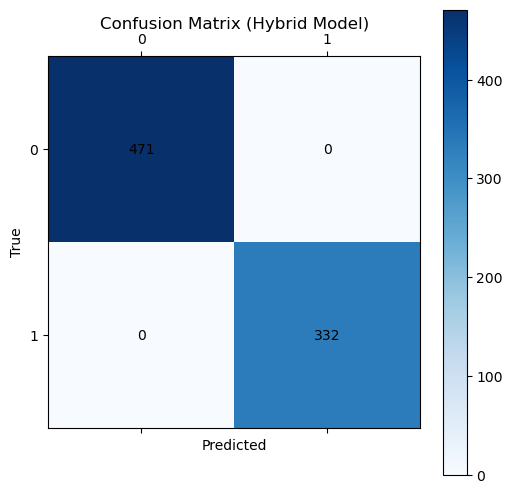

In [40]:
# Confusion Matrix for the Hybrid Model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
plt.title('Confusion Matrix (Hybrid Model)', pad=20)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center')
plt.show()

## Saving the Models for Integration

In [41]:
from joblib import dump
dump(scaler, 'scaler.pkl')

# Saving the best model API
dump(best_ocsvm, 'ocsvm_model.pkl')

['ocsvm_model.pkl']

In [42]:
dump(rf_classifier, 'hybrid_model.pkl')

['hybrid_model.pkl']